In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multitest

import cubnm
import cubnm_paper

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

thcolor = '#44546A'

# Prepare data

In [5]:
data = {}
opts = {}

for ses in ['REST1_LR', 'REST2_LR']:
    data[ses] = cubnm_paper.data.load_all_cmaes("twins_unrelated", ses, "yeo", n_runs=2)
    # create a dataframe of optimal parameters and cost function + components
    opts[ses] = pd.DataFrame({sub: data[ses][sub]['opt'] for sub in data[ses].keys()}).T

# subjects with data from both sessions
subs = sorted(list(
    set(data['REST1_LR'].keys()).intersection(set(data['REST2_LR'].keys())
)))

Loading all CMA-ES data from /raven/u/asaberi/projects/cubnm/paper/data/hcp/sim/yeo/all_cmaes_set-twins_unrelated_ses-REST1_LR_nruns-2.pkl
Loading all CMA-ES data from /raven/u/asaberi/projects/cubnm/paper/data/hcp/sim/yeo/all_cmaes_set-twins_unrelated_ses-REST2_LR_nruns-2.pkl


Create an empty `SimGroup` to use its `get_sim_fc` and `get_sim_fcd` functions for making square matrices:

In [6]:
sg = cubnm.sim.rWWSimGroup(
    sc = np.zeros((100, 100)),
    duration=900,
    TR=0.72,
    exc_interhemispheric=True
)
sg.N = 1

Load ICC values calculated in `Fig_6B-C.ipynb`:

In [7]:
pkl_file = os.path.join(cubnm_paper.config.DATA_DIR, 'hcp', 'iccs.pkl')

try:
    with open(pkl_file, 'rb') as f:
        iccs = pickle.load(f)
except FileNotFoundError as e:
    print("Run Fig_6B-C.ipynb first")
    raise e

icc_maps = {}
for k in iccs.keys():
    if not isinstance(iccs[k], np.ndarray):
        continue
    if k.endswith('edge'):
        continue
    icc_maps[k] = iccs[k]
icc_maps = pd.DataFrame(icc_maps)

Group-averaged SC-FC coupling at node level:

In [8]:
sc_fc = {}

for ses in ["REST1_LR", "REST2_LR"]:
    sc_fc[ses] = {}
    for sub in tqdm(subs):
        sc_fc[ses][sub] = pd.Series(dtype=float)
        fc_tril = data[ses][sub]['emp_fc_tril']
        sc_tril = data[ses][sub]['sc_tril']
        # create squared matrices via simgroup
        # (while considering the fact that interhemispheric
        # connections are excluded)
        sg.sim_fc_trils = fc_tril[None, :]
        fc = sg.get_sim_fc(0)
        sg.sim_fc_trils = sc_tril[None, :]
        sc = sg.get_sim_fc(0)
        for i in range(100):
            # exclude interhemispheric connections and self-connection
            mask = ~(np.isnan(fc[i]) | np.isnan(sc[i]))
            mask[i] = False
            sc_fc[ses][sub][i] = np.corrcoef(sc[i, mask], fc[i, mask])[0, 1]        

100%|██████████| 217/217 [00:07<00:00, 29.83it/s]


In [9]:
sub_sc_fc = {}
for sub in subs:
    sub_sc_fc[sub] = (sc_fc['REST1_LR'][sub] + sc_fc['REST2_LR'][sub]) / 2
sub_sc_fc = pd.DataFrame(sub_sc_fc)

In [10]:
avg_sc_fc = sub_sc_fc.mean(axis=1)
avg_sc_fc.describe()

count    100.000000
mean       0.283506
std        0.121155
min       -0.126363
25%        0.201825
50%        0.279307
75%        0.378302
max        0.535349
dtype: float64

# Spatial correlation of SC-FC coupling map with node-wise ICCs

Using spin test:

In [56]:
r = {}
p = {}

for k in tqdm(icc_maps.columns):
    r[k], p[k] = cubnm_paper.utils.spin_test(avg_sc_fc.values, icc_maps.loc[:, k])

res = pd.DataFrame({'r':r, 'p':p})
# apply FDR
_, res['p_fdr'] = statsmodels.stats.multitest.fdrcorrection(res['p'])
res.round(3)

  0%|          | 0/8 [00:00<?, ?it/s]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 12%|█▎        | 1/8 [00:02<00:15,  2.19s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 25%|██▌       | 2/8 [00:03<00:11,  1.86s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 38%|███▊      | 3/8 [00:05<00:08,  1.76s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 50%|█████     | 4/8 [00:07<00:06,  1.71s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 62%|██████▎   | 5/8 [00:08<00:05,  1.68s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 75%|███████▌  | 6/8 [00:10<00:03,  1.66s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


 88%|████████▊ | 7/8 [00:11<00:01,  1.65s/it]

Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


,r,p,p_fdr
sim_fc_strength,0.315,0.050,0.100
emp_fc_strength,-0.158,0.126,0.201
I_E,0.369,0.018,0.048
r_E,0.425,0.009,0.036
S_E,0.424,0.008,0.036
I_I,0.088,0.576,0.576
r_I,0.183,0.255,0.291
S_I,0.188,0.243,0.291


# Plot

Store screenshots of surface plots as images (to later bind them in the figure via `imshow`):

In [ ]:
imgs = {}

plotter = cubnm_paper.utils.plot_parc(avg_sc_fc.values)
imgs['sc-fc'] = plotter.screenshot(transparent_background=True)

for k in tqdm(icc_maps.columns):
    plotter = cubnm_paper.utils.plot_parc(icc_maps.loc[:, k].values, clim=(0, 1))
    imgs[k] = plotter.screenshot(transparent_background=True)

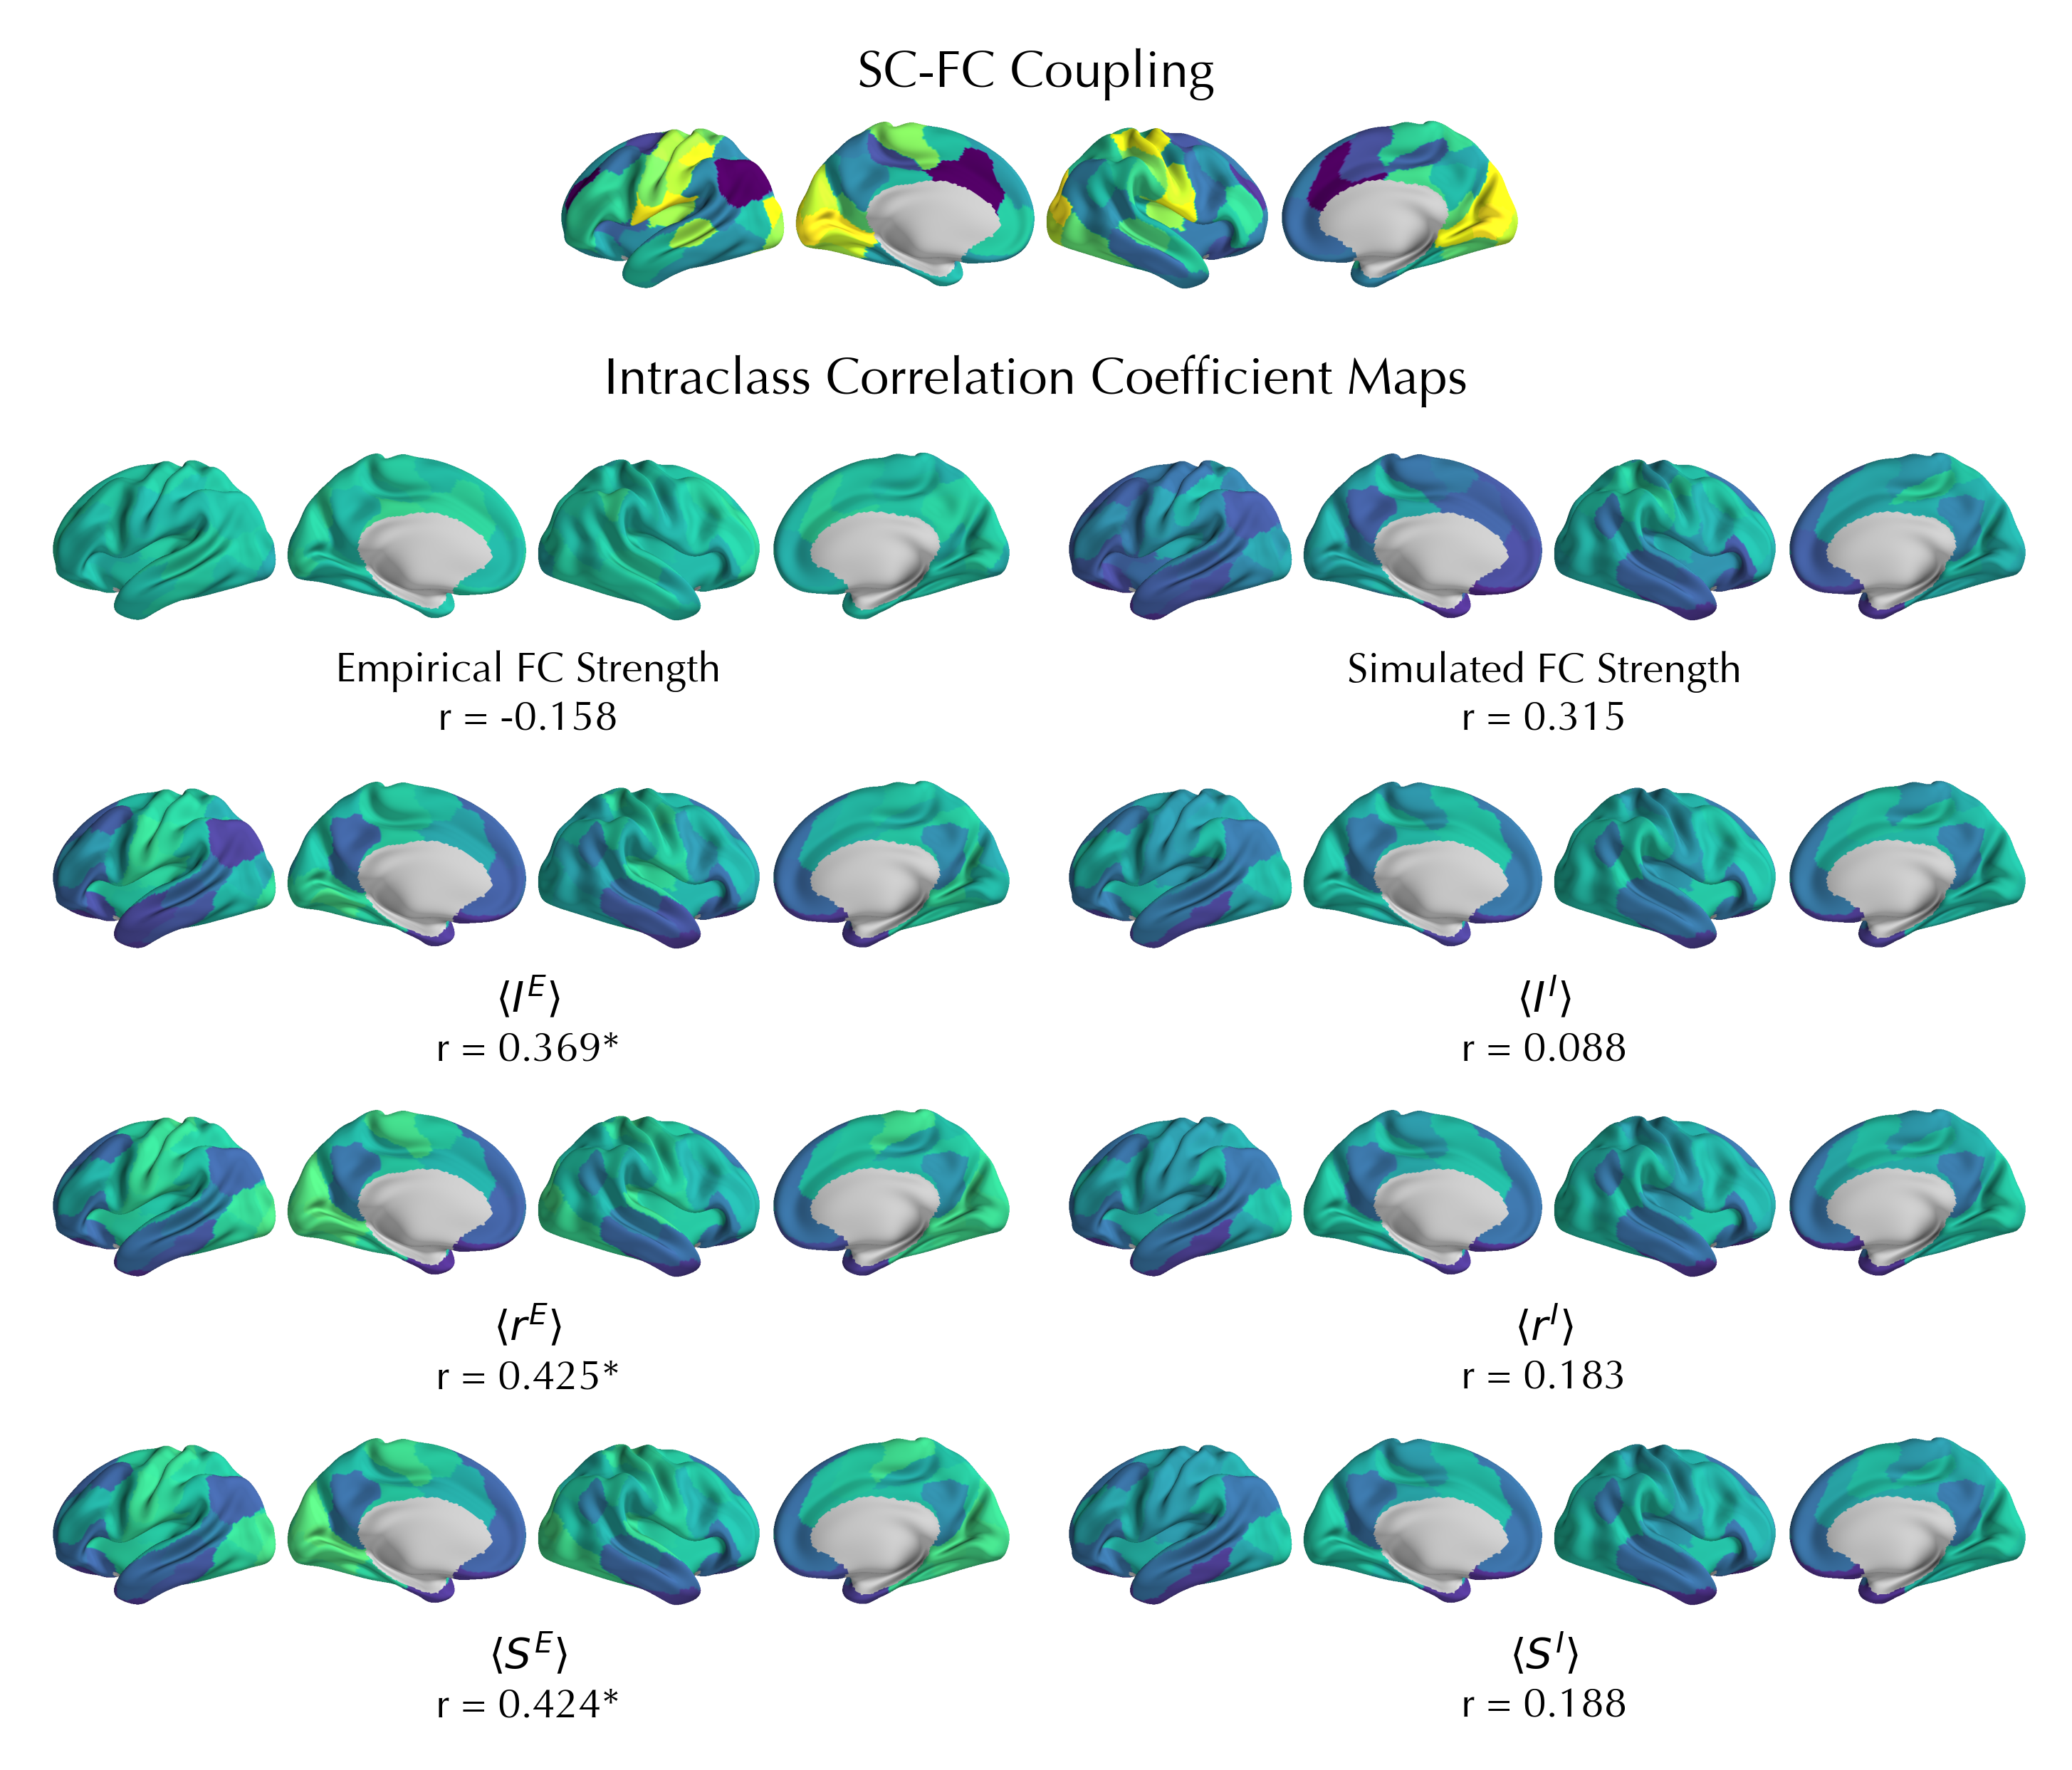

In [59]:
labels = {
    'sc-fc': 'SC-FC Coupling',
    'sim_fc_strength': 'Simulated FC Strength',
    'emp_fc_strength': 'Empirical FC Strength',
}
state_vars = sg.state_names
for var in state_vars:
    state_var, neuron = var.split('_')
    # labels[var] = r'$\langle '+state_var+r'^'+neuron+r'_i(t) \rangle_{i,t}$' # matching the main figure
    labels[var] = r'$\langle '+state_var+r'^'+neuron+r'\rangle$'


fig, axd = plt.subplot_mosaic(
    [
        ["space_l", "sc-fc", "sc-fc", "space_r"],
        ["title"]*4,
        ["emp_fc_strength"]*2+["sim_fc_strength"]*2,
        ["I_E"]*2+["I_I"]*2, 
        ["r_E"]*2+["r_I"]*2, 
        ["S_E"]*2+["S_I"]*2, 
    ],
    height_ratios=[1, 0.01, 1, 1, 1, 1],
    figsize=(6, 5.0),
    # figsize=(12, 15),
)


fontsize = 7

for i_ax, k in enumerate(imgs.keys()):
    ax = axd[k]
    im = ax.imshow(imgs[k])
    ax.axis('off')
    text = labels.get(k, k)
    if k in res.index:
        text += f"\nr = {res.loc[k, 'r']:.3f}"
        if res.loc[k, 'p_fdr']<0.05:
            text+= "*"
    if i_ax == 0:
        ax.set_title(labels.get(k, k), y=0.85, fontsize=fontsize*1.25)
    else:
        ax.text(
            ax.get_xlim()[1]/2,
            ax.get_ylim()[0]*1.15,
            text,
            va='center',
            ha='center',
            rotation=0,
            fontsize=fontsize
        )   

ax = axd['title']
ax.axis('off')
ax.text(
    ax.get_xlim()[1]/2,
    -2,
    'Intraclass Correlation Coefficient Maps', 
    va='center',
    ha='center',
    fontsize=fontsize*1.25
)


axd['space_l'].axis('off')
axd['space_r'].axis('off')


plt.subplots_adjust(wspace=0.1, hspace=0)
fig.savefig('icc_sc_fc.png', transparent=True, bbox_inches='tight')

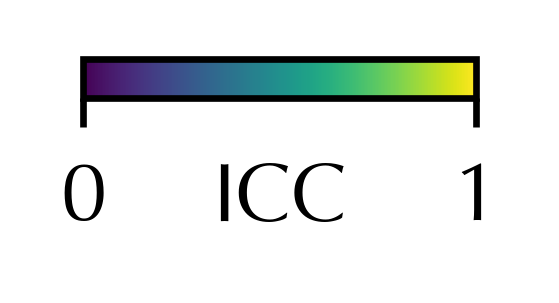

In [3]:
fig = cubnm_paper.utils.make_colorbar(0, 1, 'viridis', figsize=(2, 1), label='ICC', orientation='horizontal');
fig.savefig('icc_cbar_h.svg', transparent=True, bbox_inches='tight')

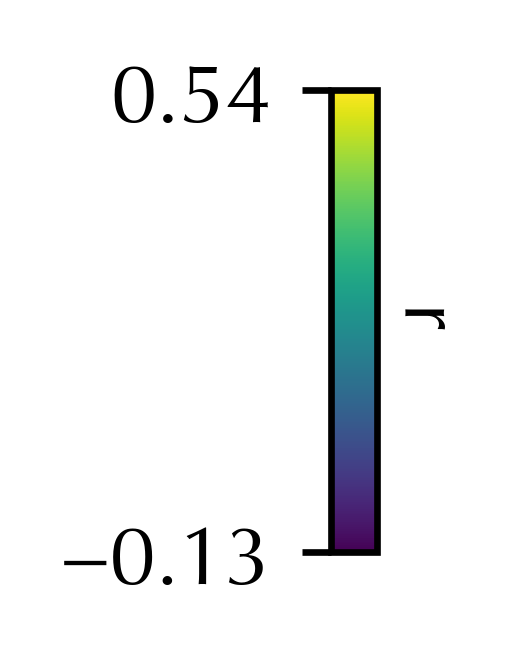

In [11]:
fig = cubnm_paper.utils.make_colorbar(avg_sc_fc.min().round(2), avg_sc_fc.max().round(2), 'viridis', figsize=(2, 1), label='r');
fig.savefig('sc_fc_cbar.svg', transparent=True, bbox_inches='tight')